<a href="https://colab.research.google.com/github/Series-Parallel/Machine_in_Deep_Learning/blob/main/encoder_decoder_transformer_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

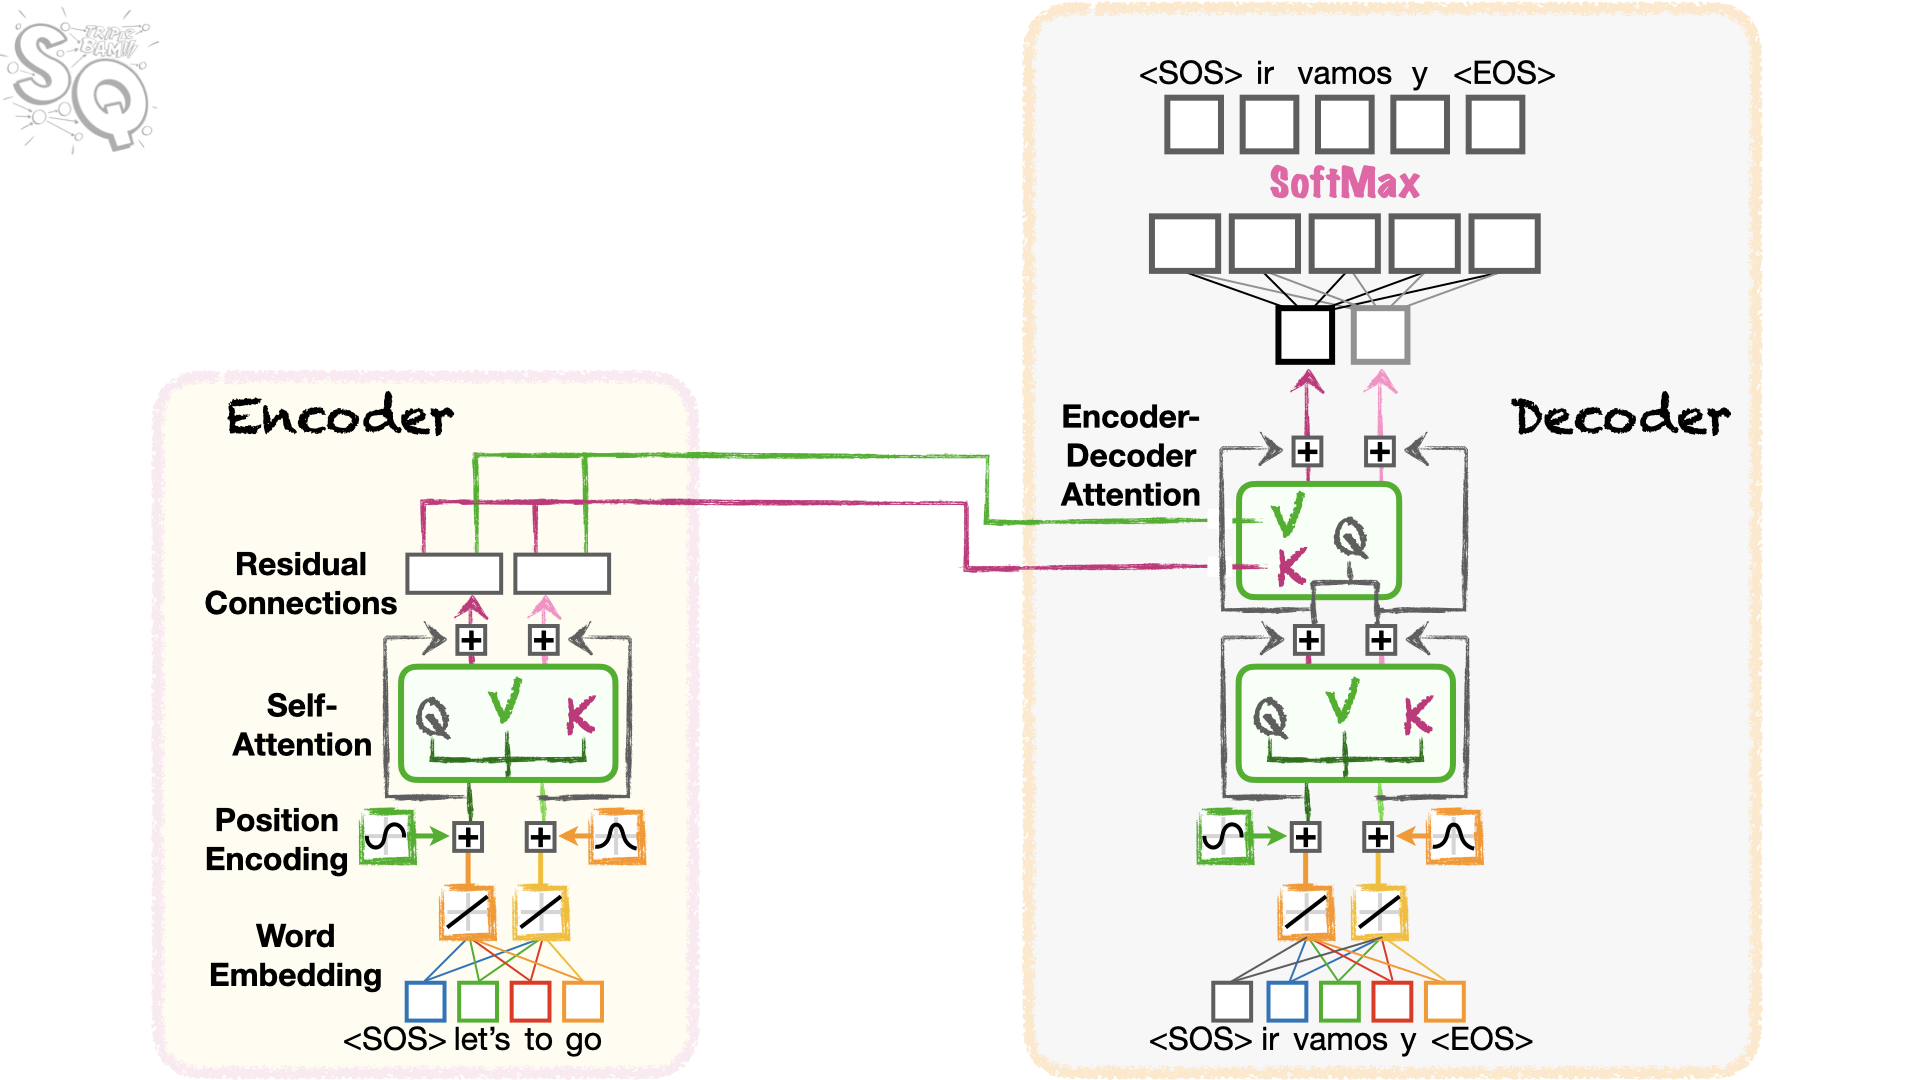

In [ ]:
import pip
try:
  __import__("lightning")
except ImportError:
  pip.main(['install', "lightning"])

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import lightning as L
from torch.utils.data import TensorDataset, DataLoader

# The input and output vocabularies and data

In [ ]:
input_vocab = {'<SOS>': 0,
               'lets': 1,
               'to': 2,
               'go': 3}

In [ ]:
output_vocab = {'<SOS>': 0,
                'ir': 1,
                'vamos': 2,
                'y': 3,
                '<EOS>': 4}


In [ ]:
inputs = torch.tensor([[1, 3],
                       [2, 3]])

In [ ]:
labels = torch.tensor([[2],
                      [1]])

In [ ]:
dataset = TensorDataset(inputs, labels)
dataloader = DataLoader(dataset)

# Position Encoding

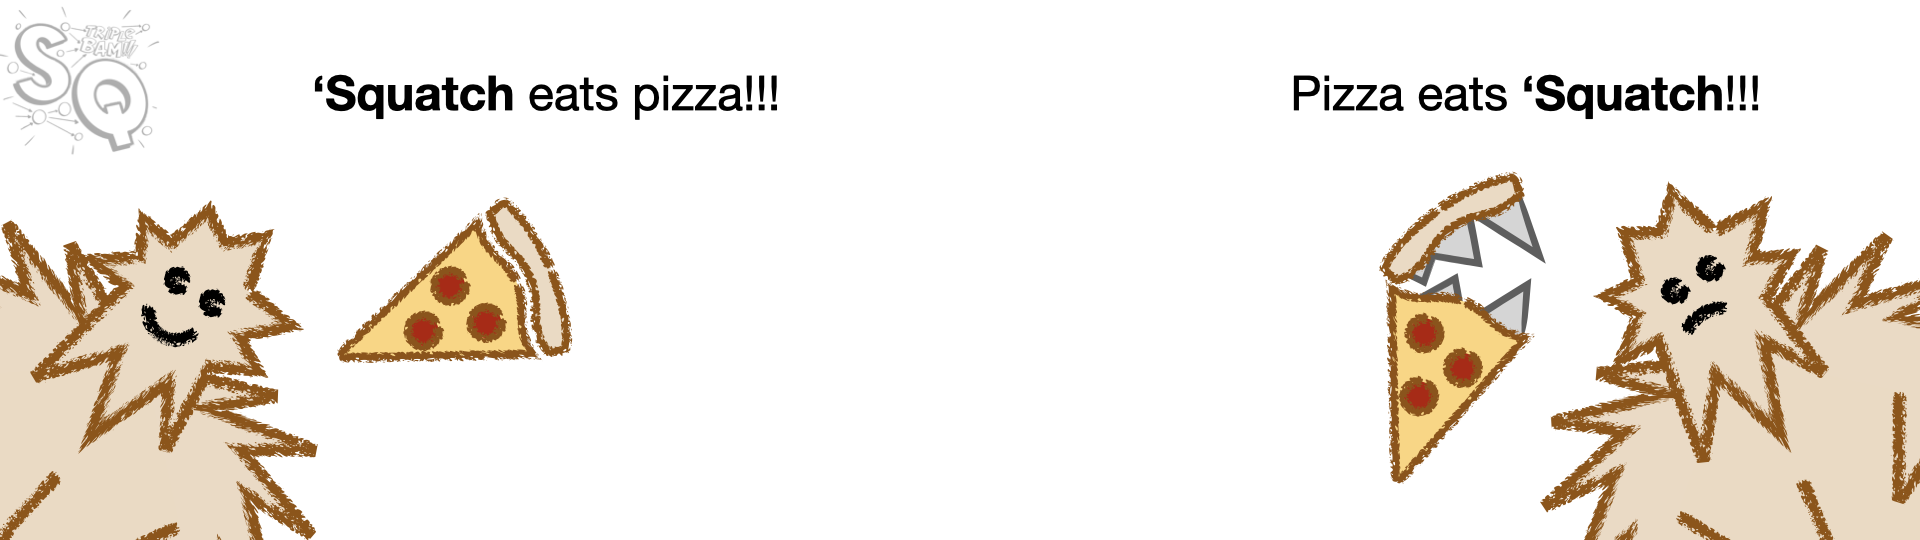

In [ ]:
class PositionEncoding(nn.Module):
  def __init__(self, d_model=2, max_len=3):
    super().__init__()
    pe = torch.zeros(max_len, d_model)
    position = torch.arange(start=0, end=max_len, step=1).float().unsqueeze(1)

    ## PE(pos, 2i)   = sin(pos / 10000^(2i/d_model))
    ## PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))

    div_term = 1/torch.tensor(10000.0)**(torch.arange(start=0, end=d_model, step=2).float() / d_model)

    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)

    self.register_buffer('pe', pe)

  def forward(self, x):
    return x + self.pe[:x.size(0), :]

# Attention

In [ ]:
class Attention(nn.Module):
  def __init__(self, d_model=2):
    super().__init__()

    self.W_q = nn.Linear(in_features=d_model, out_features=d_model, bias=False)
    self.W_k = nn.Linear(in_features=d_model, out_features=d_model, bias=False)
    self.W_v = nn.Linear(in_features=d_model, out_features=d_model, bias=False)

    self.row_dim = 0
    self.col_dim = 1

  def forward(self, encodings_for_q, encodings_for_k, encodings_for_v, mask=None):

    q = self.W_q(encodings_for_q)
    k = self.W_k(encodings_for_k)
    v = self.W_v(encodings_for_v)

    sims = torch.matmul(q, k.transpose(dim0=self.row_dim, dim1=self.col_dim))
    scaled_sims = sims / torch.tensor(q.size(self.col_dim)**0.5)

    if mask is not None:
      scaled_sims = scaled_sims.masked_fill(mask=mask, value=-1e9)

    attention_percents = F.softmax(scaled_sims, dim=self.col_dim)
    attention_scores = torch.matmul(attention_percents, v)

    return attention_scores

# The Encoder Class

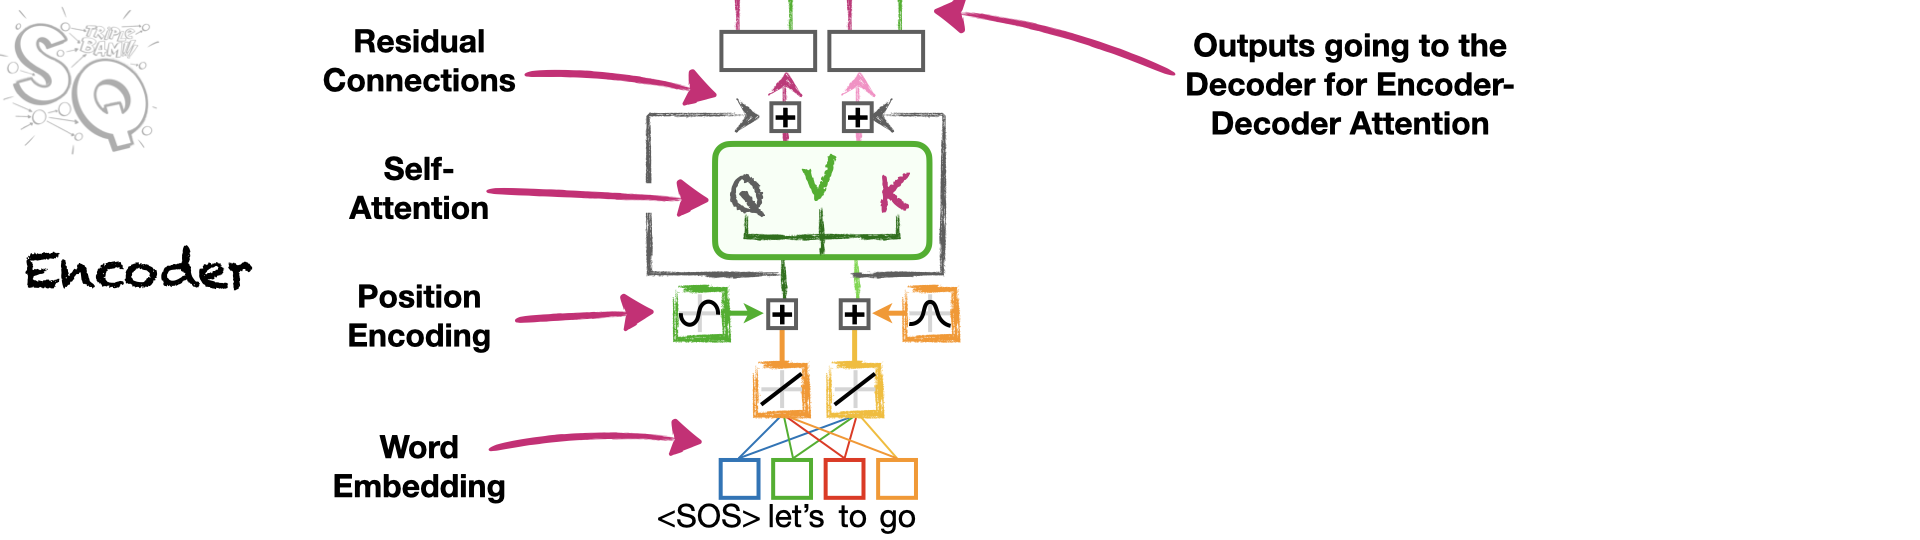

A basic Encoder simply brings together...

* Word Embedding
* Position Encoding
* Self-Attention
* Residual Connections

In [ ]:
class Encoder(nn.Module):
  def __init__(self, num_tokens=4, d_model=2, max_len=3):
    super().__init__()
    L.seed_everything(seed=42)

    self.we = nn.Embedding(num_embeddings=num_tokens,
                               embedding_dim=d_model)

    self.pe = PositionEncoding(d_model=d_model,
                                   max_len=max_len)

    self.self_attention = Attention(d_model=d_model)

  def forward(self, token_ids):
    word_embeddings = self.we(token_ids)
    position_encoded = self.pe(word_embeddings)
    self_attention_values = self.self_attention(position_encoded,
                                                    position_encoded,
                                                    position_encoded)
    output_values = position_encoded + self_attention_values

    return output_values

# **The Decoder Class**

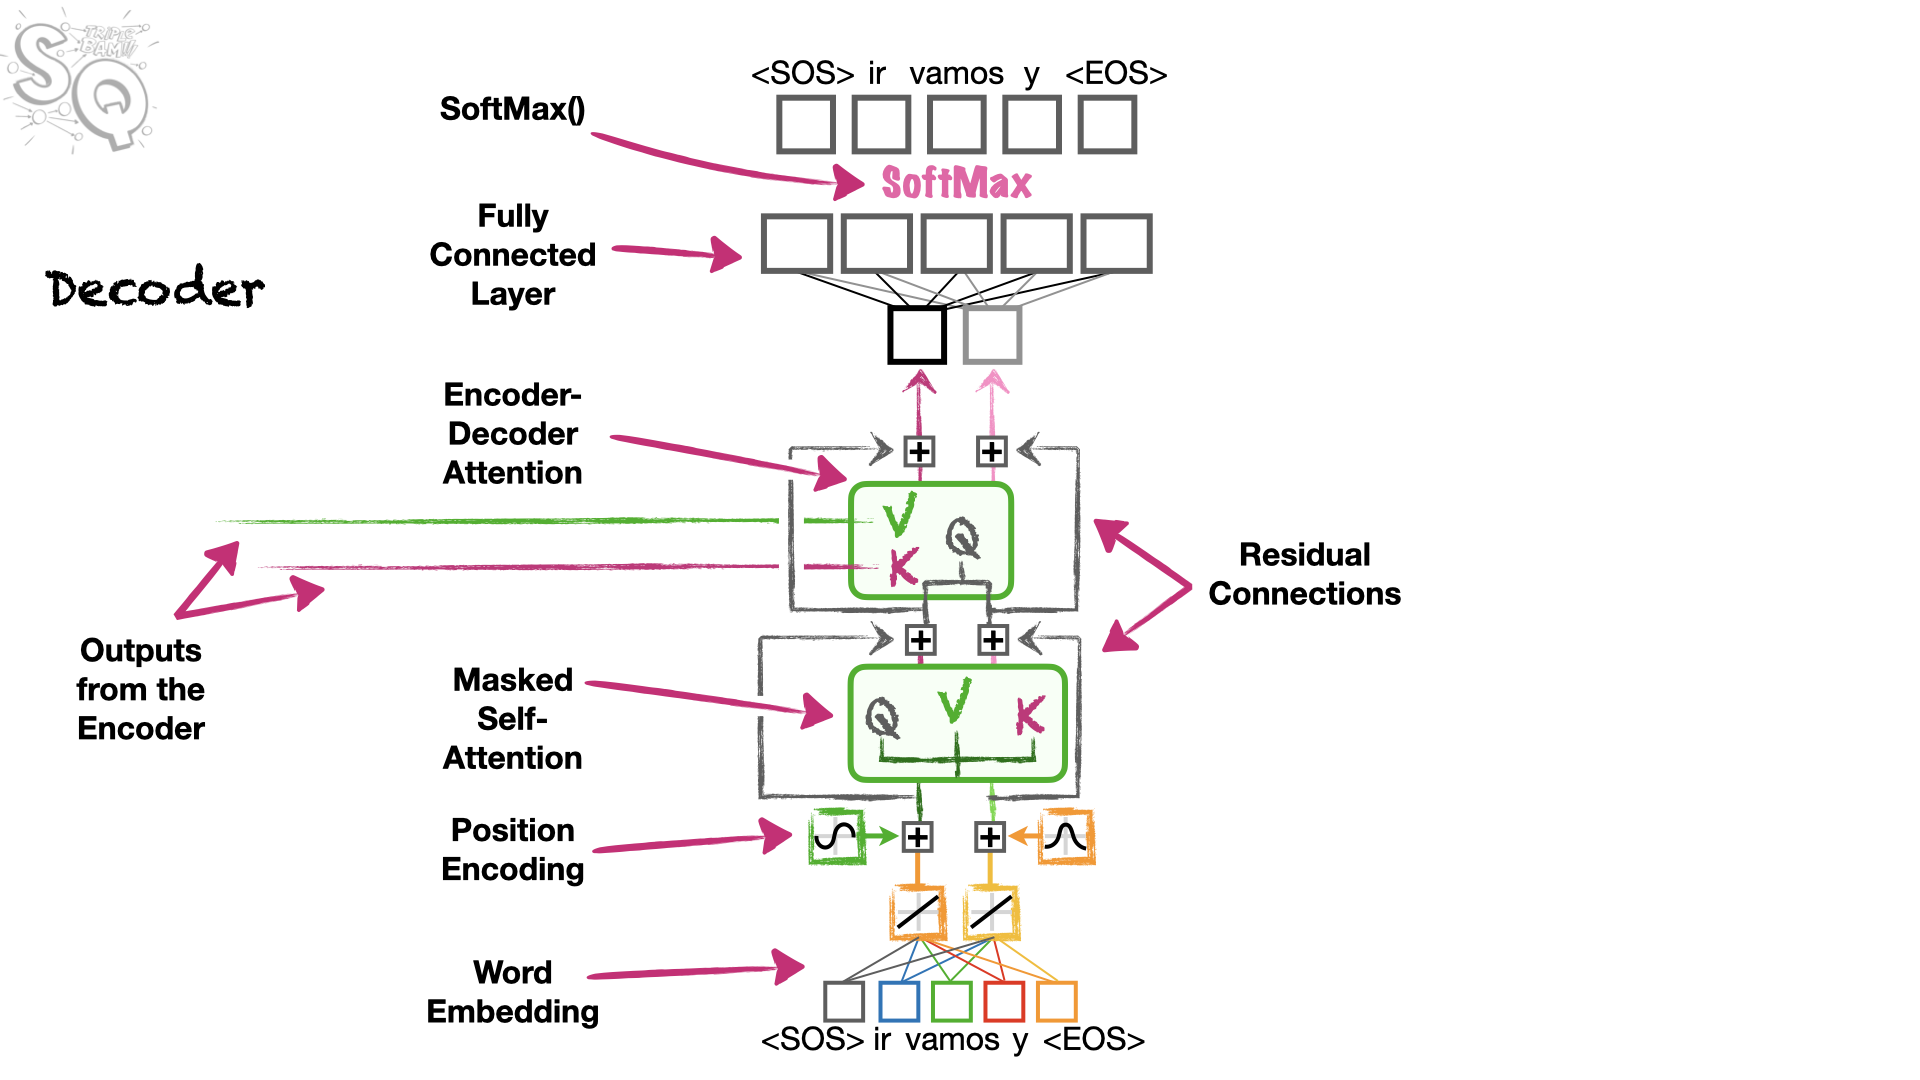

A basic Decoder simply brings together...


*   Word Embedding
*   Position Encoding
* Self-Attention
* Residual Connections
* Encoder-Decoder Attention
* A fully connected layer
* SoftMax



In [ ]:
class Decoder(nn.Module):

  def __init__(self, num_tokens=4, d_model=2, max_len=3):
    super().__init__()
    L.seed_everything(seed=43)

    self.we = nn.Embedding(num_embeddings=num_tokens,
                               embedding_dim=d_model)
    self.pe = PositionEncoding(d_model=d_model,
                                   max_len=max_len)
    self.self_attention = Attention(d_model=d_model)

    self.enc_dec_attention = Attention(d_model=d_model)

    self.fc_layer = nn.Linear(in_features=d_model, out_features=num_tokens)

    self.row_dim = 0
    self.col_dim = 1

  def forward(self, token_ids, encoder_values):
    word_embeddings = self.we(token_ids)
    position_encoded = self.pe(word_embeddings)
    mask = torch.tril(torch.ones((token_ids.size(dim=self.row_dim), token_ids.size(dim=self.row_dim))))
    mask = mask == 0

    self_attention_values = self.self_attention(position_encoded,
                                                    position_encoded,
                                                    position_encoded,
                                                    mask=mask)
    residual_connection_values = position_encoded + self_attention_values
    enc_dec_attention_values = self.enc_dec_attention(residual_connection_values,
                                                          encoder_values,
                                                          encoder_values)

    residual_connection_values = enc_dec_attention_values + residual_connection_values
    fc_layer_output = self.fc_layer(residual_connection_values)

    return fc_layer_output


# **The Transformer Class**

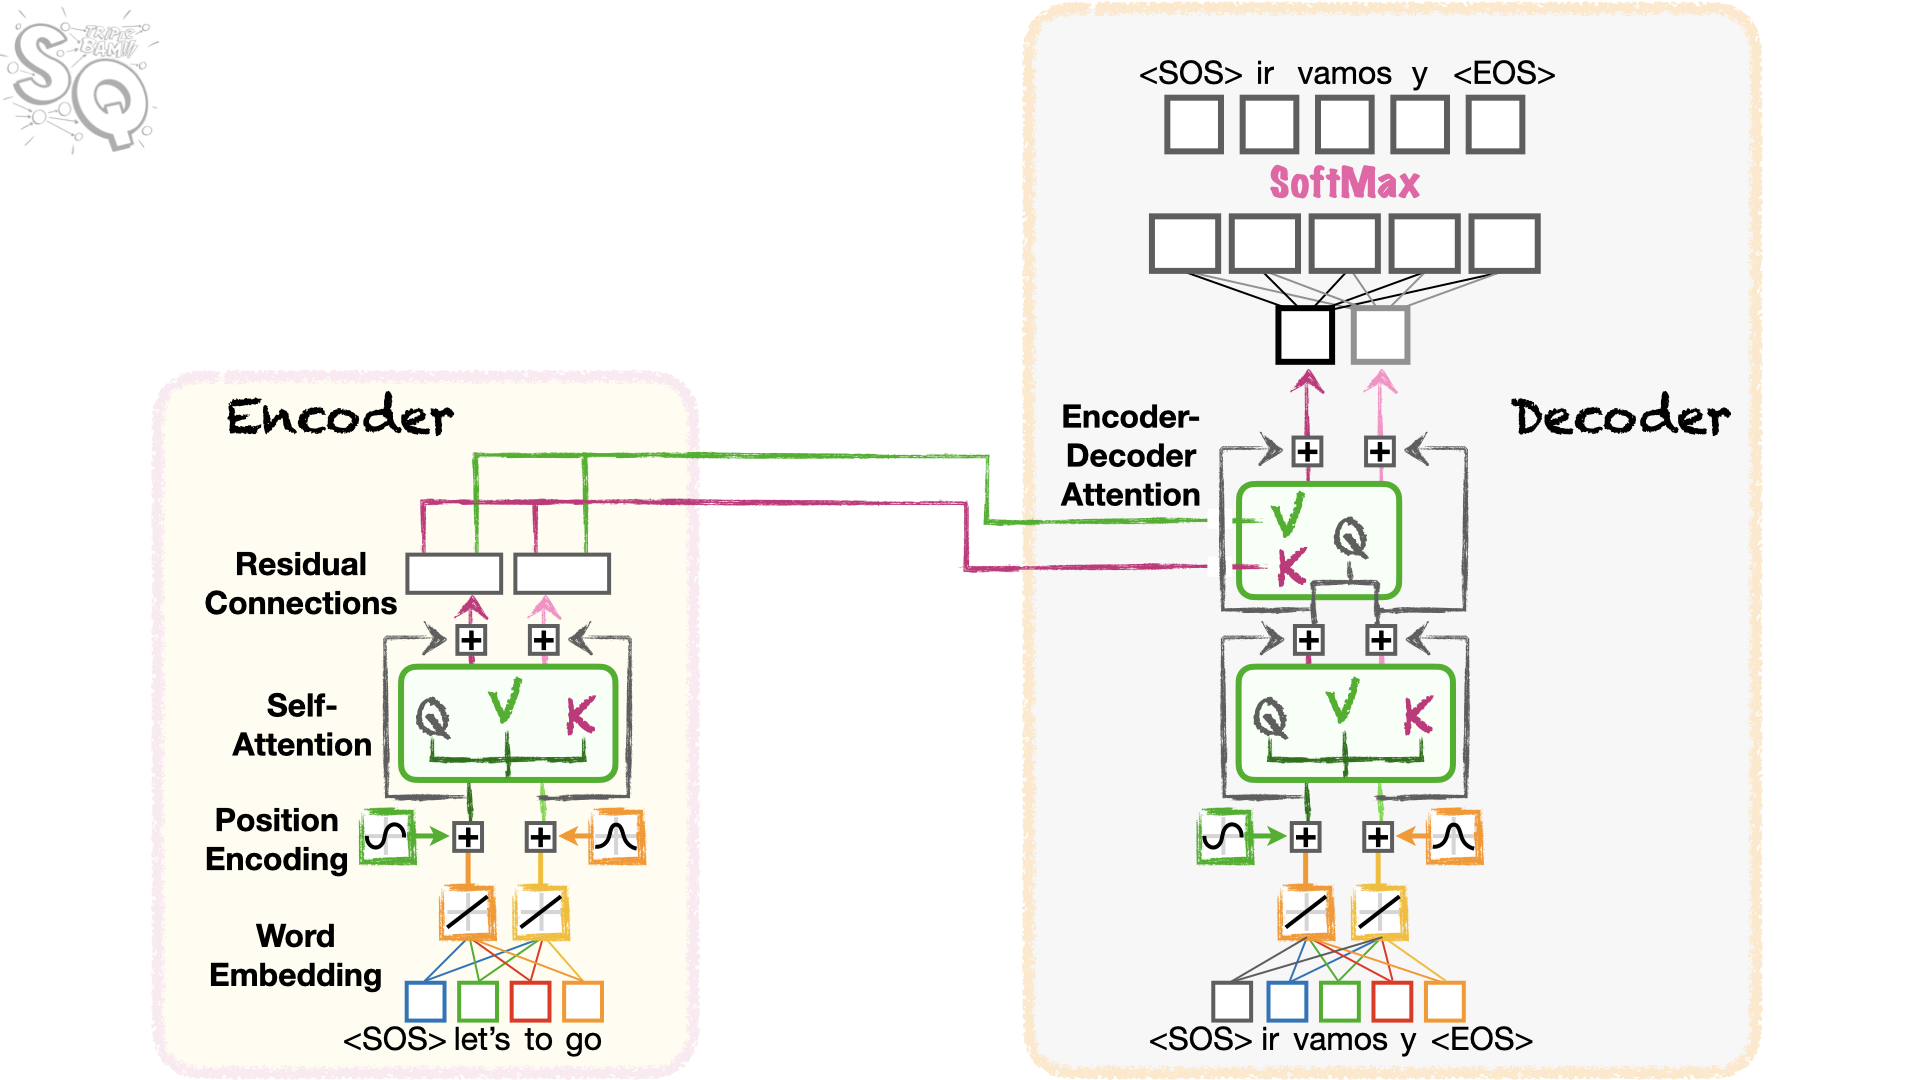

In [ ]:
class Transformer(L.LightningModule):
  def __init__(self, input_size, output_size, d_model=2, max_len=3):
    super().__init__()

    self.encoder = Encoder(num_tokens=len(input_vocab), d_model=d_model, max_len=max_len)
    self.decoder = Decoder(num_tokens=len(output_vocab), d_model=d_model, max_len=max_len)

    self.loss = nn.CrossEntropyLoss()

  def forward(self, inputs, labels):
    encoder_values = self.encoder(inputs)
    output_presoftmax = self.decoder(labels, encoder_values)
    return(output_presoftmax)

  def configure_optimizers(self):
    return Adam(self.parameters(), lr=0.1)

  def training_step(self, batch, batch_idx):
    input_i, label_i = batch

    input_tokens = torch.cat((torch.tensor([0]), input_i[0]))
    teacher_forcing = torch.cat((torch.tensor([0]), label_i[0]))

    expected_output = torch.cat((label_i[0], torch.tensor([4])))
    output_i = self.forward(input_tokens, teacher_forcing)
    loss = self.loss(output_i, expected_output)

    return loss

In [ ]:
max_length = 3
transformer = Transformer(len(input_vocab), len(output_vocab), d_model=2, max_len=max_length)
encoder_values = transformer.encoder(torch.tensor([0, 1, 3]))

predicted_ids = torch.tensor([0])

for i in range(max_length):
  prediction = transformer.decoder(predicted_ids, encoder_values)


  predicted_id = torch.tensor([torch.argmax(prediction[-1,:])])
  predicted_ids = torch.cat((predicted_ids, predicted_id))

  if (predicted_id == 4):
    break

print("\npredicted_ids:", predicted_ids)

# Train the Transformer!!!

In [ ]:
transformer = Transformer(len(input_vocab), len(output_vocab), d_model=2, max_len=3)

In [ ]:
trainer = L.Trainer(max_epochs=30)
trainer.fit(transformer, train_dataloaders=dataloader)

In [ ]:
max_length = 3
row_dim = 0
col_dim = 1

encoder_values = transformer.encoder(torch.tensor([0, 1, 3]))
predicted_ids = torch.tensor([0])
for i in range(max_length):
  prediction = transformer.decoder(predicted_ids, encoder_values)
  predicted_id = torch.tensor([torch.argmax(prediction[-1,:])])
  predicted_ids = torch.cat((predicted_ids, predicted_id))

  if (predicted_id == 4): # if the prediction is <EOS>, then we are done
        break

print("\npredicted_ids:", predicted_ids)